# AI Query Tube

## 1. Setup and Imports

In [7]:
%pip install youtube-transcript-api sentence-transformers tf-keras

import os
import sys
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api._errors import TranscriptsDisabled, NoTranscriptFound, VideoUnavailable
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

Note: you may need to restart the kernel to use updated packages.


## 2. YouTube Data Collection

In [8]:
API_KEY = os.environ.get('YOUTUBE_API_KEY')
if API_KEY is None:
    raise RuntimeError('Set YOUTUBE_API_KEY in the environment before running this notebook')
CHANNEL_ID = "UC4SVo0Ue36XCfOyb5Lh1viQ"

In [9]:
url = "https://www.googleapis.com/youtube/v3/search"
params = {
    "key": API_KEY,
    "channelId": CHANNEL_ID,
    "part": "snippet,id",
    "order": "date",
    "maxResults": 50,
    "hl": "en",
    "regionCode": "US"
}

def extract_video_fields(item):
    video_id = item["id"]["videoId"]
    title = item["snippet"]["title"]
    published = item["snippet"]["publishedAt"]
    return video_id, title, published 

videos = []
next_page_token = None


# Set a limit of pages to fetch to avoid infinite loops if something goes wrong, or remove for full channel
max_pages = 10
page_count = 0

while True:
    if next_page_token:
        params['pageToken'] = next_page_token

    try:
        resp = requests.get(url, params=params, timeout=10)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        print('Request failed:', e)
        break

    for item in data.get("items", []):
        if "videoId" in item.get("id", {}):
            video_id, title, published = extract_video_fields(item)
            videos.append([video_id, title, published])

    next_page_token = data.get("nextPageToken")
    page_count += 1
    if not next_page_token or page_count >= max_pages:
        break

df = pd.DataFrame(videos, columns=["video_id", "title", "published_date"])
df.to_csv("youtube_metadata.csv", index=False)
display(df.head())

,video_id,title,published_date
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z


## 3. Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   video_id        120 non-null    object
 1   title           120 non-null    object
 2   published_date  120 non-null    object
dtypes: object(3)
memory usage: 2.9+ KB


None

,video_id,title,published_date
count,120,120,120
unique,120,120,120
top,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z
freq,1,1,1


Missing values:
video_id          0
title             0
published_date    0
dtype: int64


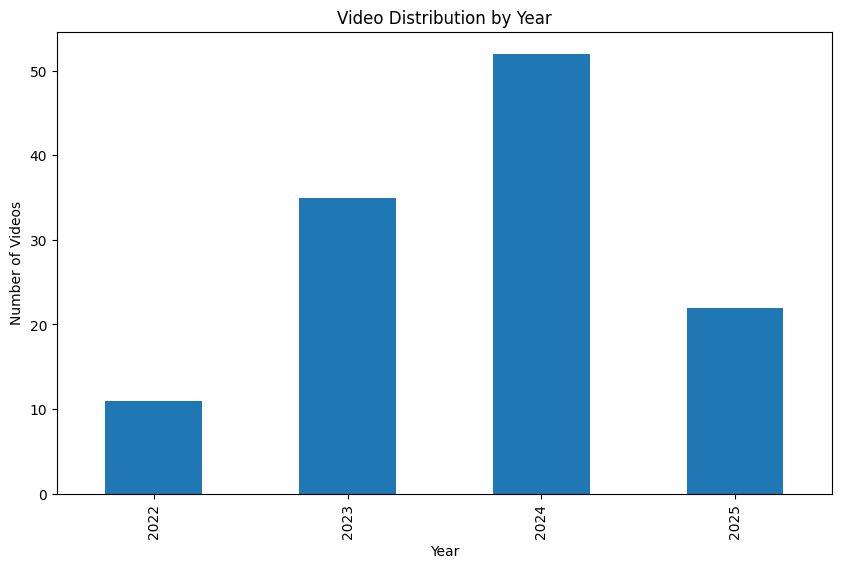

In [10]:
# Basic info
display(df.info())
display(df.describe())

# Missing values
print("Missing values:")
print(df.isnull().sum())

# Publish date distribution
df['published_date'] = pd.to_datetime(df['published_date'])
plt.figure(figsize=(10, 6))
df['published_date'].dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Video Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Videos')
plt.show()

## 4. Transcript Extraction and Text Cleaning

In [11]:

import pandas as pd
import time
from youtube_transcript_api import YouTubeTranscriptApi

# Load existing CSV (IMPORTANT)
df = pd.read_csv("youtube_metadata.csv")

# If transcript column doesn't exist, create it
if "transcript" not in df.columns:
    df["transcript"] = None

ytt_api = YouTubeTranscriptApi()
LIMIT = 10
DELAY = 1.0

# Fetch transcripts only for first 10 videos
for idx, vid in enumerate(df["video_id"].head(LIMIT)):
    try:
        transcript_object = ytt_api.fetch(vid)

        text = " ".join(
            snippet.text for snippet in transcript_object.snippets
        )

        # 🔥 Update ONLY that row
        df.loc[idx, "transcript"] = text
        print(f"✅ Success ({idx+1}/{LIMIT}): {vid}")

    except Exception as e:
        df.loc[idx, "transcript"] = None
        print(f"❌ Failed ({idx+1}/{LIMIT}): {vid} | {type(e).__name__}")

    time.sleep(DELAY)

# Save back to SAME file (safe overwrite)
df.to_csv("youtube_metadata.csv", index=False)

print("🎉 Transcript column updated for top 10 videos")

# Preview
df.head(12)


✅ Success (1/10): fPopFeqw5sk
✅ Success (2/10): xf71dRBRP6o
✅ Success (3/10): k0D3MQwLn7A
✅ Success (4/10): ZBlxaXMN_hU
✅ Success (5/10): c9vhHUGdav0
✅ Success (6/10): OUnnuKHbmbU
✅ Success (7/10): 6WaBryk4fkE
✅ Success (8/10): mjiHc965UME
✅ Success (9/10): sHrlK5tOGpw
✅ Success (10/10): tg5Wv9Ba1lI
🎉 Transcript column updated for top 10 videos


,video_id,title,published_date,transcript
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z,"Yo, hello again everybody. In this video, I'm ..."
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z,"What is going on everybody? In this video, I t..."
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z,"Hey, what is going on everybody? In this video..."
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z,"All right, everybody. In this video, I'm going..."
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z,"Hey everybody. In this video, I'm going to tea..."
5,OUnnuKHbmbU,DataFrames in Pandas are easy! 🔢,2025-09-04T14:00:37Z,"All right, let's do this everybody. We got to ..."
6,6WaBryk4fkE,Slicing in NumPy is easy! ✂️,2025-07-27T15:25:48Z,"Yo, hey everybody. In this video, I'm going to..."
7,mjiHc965UME,Convert decimal to hexadecimal EASY! #coding ...,2025-07-20T14:51:42Z,"Yo, hey everybody. In this video, I'm going to..."
8,sHrlK5tOGpw,Learn hexadecimal in 0x79 seconds #coding #com...,2025-07-16T14:10:13Z,"In this video, I'm going to show you how to ea..."
9,tg5Wv9Ba1lI,Learn binary in 01000000 seconds #coding #comp...,2025-07-13T15:43:58Z,Here's how to read binary numbers in roughly 6...


## 5. Embeddings and Search

In [33]:
model = SentenceTransformer("all-MiniLM-L6-v2")

df["text_for_embedding"] = df["title"] + " " + df["transcript"].fillna("")
df["embedding"] = df["text_for_embedding"].apply(lambda x: model.encode(x))

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [35]:
query = "PHP tutorials"

query_embedding = model.encode(query)

scores = cosine_similarity([query_embedding], list(df["embedding"]))
top_idx = scores[0].argsort()[-5:][::-1]  # Top 5 results

results = df.iloc[top_idx][["title", "video_id"]].copy()
results["score"] = scores[0][top_idx]
display(results)

c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


,title,video_id,score
4,Learn Matplotlib in 1 hour! 📊,c9vhHUGdav0,0.255413
1,Build a music player with Python! 🎶,xf71dRBRP6o,0.181588
0,Learn NumPy data types in 8 minutes! 💱,fPopFeqw5sk,0.105624
2,Learn Python iterators in 7 minutes! ➡️,k0D3MQwLn7A,0.072265
9,Learn binary in 01000000 seconds #coding #comp...,tg5Wv9Ba1lI,0.064241


In [15]:
!pip install -q sentence-transformers scikit-learn pandas numpy
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


In [16]:
df = pd.read_csv("youtube_metadata.csv")

df = df.dropna(subset=["transcript"]).reset_index(drop=True)

df.head()


,video_id,title,published_date,transcript
0,fPopFeqw5sk,Learn NumPy data types in 8 minutes! 💱,2025-11-21T15:40:45Z,"Yo, hello again everybody. In this video, I'm ..."
1,xf71dRBRP6o,Build a music player with Python! 🎶,2025-11-20T16:51:00Z,"What is going on everybody? In this video, I t..."
2,k0D3MQwLn7A,Learn Python iterators in 7 minutes! ➡️,2025-11-10T14:21:48Z,"Hey, what is going on everybody? In this video..."
3,ZBlxaXMN_hU,Learn Python generator expressions in 9 minute...,2025-11-07T15:08:16Z,"All right, everybody. In this video, I'm going..."
4,c9vhHUGdav0,Learn Matplotlib in 1 hour! 📊,2025-10-09T14:01:03Z,"Hey everybody. In this video, I'm going to tea..."


In [17]:
df["combined_text"] = df["title"] + " " + df["transcript"]


In [18]:
models = {
    "all-MiniLM-L6-v2": SentenceTransformer("all-MiniLM-L6-v2"),
    "paraphrase-MiniLM-L6-v2": SentenceTransformer("paraphrase-MiniLM-L6-v2"),
    "all-mpnet-base-v2": SentenceTransformer("all-mpnet-base-v2")
}


c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\adity\.cache\huggingface\hub\models--sentence-transformers--paraphrase-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is no

In [19]:
queries = [
    "how to learn python",
    "machine learning basics",
    "deep learning tutorial",
    "data science roadmap",
    "neural networks explained"
]


In [20]:
def evaluate_ranking(distances, correct_index):
    ranking = np.argsort(distances)
    rank = np.where(ranking == correct_index)[0][0] + 1
    
    return {
        "rank": rank,
        "top_1": int(rank == 1),
        "top_3": int(rank <= 3)
    }


In [23]:
results = []

for model_name, model in models.items():
    print(f"Evaluating model: {model_name}")
    
    video_embeddings = model.encode(
        df["combined_text"].tolist(),
        show_progress_bar=True
    )
    
    query_embeddings = model.encode(
        queries,
        show_progress_bar=True
    )
    
    for metric in ["cosine", "euclidean", "cityblock", "chebyshev"]:

        
        if metric == "cosine":
            distance_matrix = 1 - cosine_similarity(query_embeddings, video_embeddings)
        else:
            distance_matrix = cdist(query_embeddings, video_embeddings, metric)
        
        ranks = []
        top1 = []
        top3 = []
        
        for i in range(len(queries)):
            correct_index = i % len(df)  # proxy mapping
            eval_result = evaluate_ranking(distance_matrix[i], correct_index)
            
            ranks.append(eval_result["rank"])
            top1.append(eval_result["top_1"])
            top3.append(eval_result["top_3"])
        metric_name = "manhattan" if metric == "cityblock" else metric

        results.append({
                "model": model_name,
                "metric": metric_name,
                "avg_rank": np.mean(ranks),
                "top1_recall": np.mean(top1),
                "top3_recall": np.mean(top3)
                })



Evaluating model: all-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 1/1 [00:00<00:00, 70.66it/s]


Evaluating model: paraphrase-MiniLM-L6-v2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\adity\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Batches: 100%|██████████| 1/1 [00:00<00:00, 65.68it/s]


Evaluating model: all-mpnet-base-v2


Batches: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]


In [24]:
results_df = pd.DataFrame(results)
results_df


,model,metric,avg_rank,top1_recall,top3_recall
0,all-MiniLM-L6-v2,cosine,6.2,0.0,0.2
1,all-MiniLM-L6-v2,euclidean,6.2,0.0,0.2
2,all-MiniLM-L6-v2,manhattan,5.0,0.0,0.6
3,all-MiniLM-L6-v2,chebyshev,6.4,0.0,0.2
4,paraphrase-MiniLM-L6-v2,cosine,7.2,0.0,0.2
5,paraphrase-MiniLM-L6-v2,euclidean,7.4,0.0,0.2
6,paraphrase-MiniLM-L6-v2,manhattan,7.6,0.0,0.2
7,paraphrase-MiniLM-L6-v2,chebyshev,7.2,0.0,0.2
8,all-mpnet-base-v2,cosine,6.4,0.2,0.2
9,all-mpnet-base-v2,euclidean,6.4,0.2,0.2


In [25]:
best_model = results_df.sort_values(
    by=["top3_recall", "top1_recall", "avg_rank"],
    ascending=[False, False, True]
).iloc[0]

best_model


model          all-MiniLM-L6-v2
metric                manhattan
avg_rank                    5.0
top1_recall                 0.0
top3_recall                 0.6
Name: 2, dtype: object

In [26]:
print("✅ BEST MODEL SELECTION SUMMARY\n")
print(f"Model        : {best_model['model']}")
print(f"Metric       : {best_model['metric']}")
print(f"Avg Rank     : {best_model['avg_rank']:.2f}")
print(f"Top-1 Recall : {best_model['top1_recall']:.2f}")
print(f"Top-3 Recall : {best_model['top3_recall']:.2f}")


✅ BEST MODEL SELECTION SUMMARY

Model        : all-MiniLM-L6-v2
Metric       : manhattan
Avg Rank     : 5.00
Top-1 Recall : 0.00
Top-3 Recall : 0.60


# Module 6: Building a Video Index Using Embeddings